# Chapter 20 - Generative Adversarial Networks

## 20.1. Generative Adversarial Networks

Generative adversarial networks (GANs) leverage the power of discriminative models to get good generative models. GANs rely on the idea that a data generator is good if we cannot tell fake data apart from real data. In statistics, this is called a two-sample test - a test to answer the question whether datasets $X=\{x_1,\ldots, x_n\}$ and $X'=\{x'_1,\ldots, x'_n\}$ were drawn from the same distribution.

![](../imgs/ch20/gan.svg)

The figure above shows the GAN arhictecture. The generator is able to generate data that looks just like the real thing. The discriminator is able to distinguish fake and real data from each other. Both networks are in competition with each other. The generator network attempts to fool the discriminator network.

The discriminator is a binary classifier to distinguish if the input $x$ is real (from real data) or fake (from the generator). The discriminator outputs a scalar prediction $o\in\mathbb R$ for input $\mathbf{x}$, such as using a fully connected layer with hidden size 1, and then applies sigmoid function to obtain the predicted probability $D(\mathbf x) = 1/(1+e^{-o})$. Assume the label $y$ for the true data is 1 and 0 for the fake data. We train the discriminator to minimize the cross-entropy loss:
\begin{split}
\min_D \{ - y \log D(\mathbf x) - (1-y)\log(1-D(\mathbf x)) \}.
\end{split}

The generator first draws some parameter $\mathbf z\in\mathbb R^d$ from a source of randomness, e.g., a normal distribution $\mathbf z \sim \mathcal{N} (0, 1)$, where $\mathbf{z}$ is called the latent variable. Then, the generator applies a function to generate $\mathbf x'=G(\mathbf z)$. The goal is to fool the discriminator to classify $\mathbf x'=G(\mathbf z)$ as true data, i.e., we want $D( G(\mathbf z)) \approx 1$.

In other words, for a given discriminator $D$, we update the parameters of the generator $G$ to maximize the cross-entropy loss when $y=0$, i.e.,
\begin{split}
\max_G \{ - (1-y) \log(1-D(G(\mathbf z))) \} = \max_G \{ - \log(1-D(G(\mathbf z))) \}.
\end{split}

If the generator does a perfect job, then $D(\mathbf x')\approx 1$, so the above loss is close to 0, which results in the gradients that are too small to make good progress for the discriminator. Therefore, we commonly minimize the following loss for the generator:
\begin{split}
\min_G \{ - y \log(D(G(\mathbf z))) \} = \min_G \{ - \log(D(G(\mathbf z))) \},
\end{split}
which is just feeding $\mathbf x'=G(\mathbf z)$ into the discriminator but giving label $y=1$.

To sum up, $D$ and $G$ are playing a "minmax" game with the comprehensive objective function:
\begin{split}
\min_D \max_G \{ -E_{x \sim \textrm{Data}} \log D(\mathbf x) - E_{z \sim \textrm{Noise}} \log(1 - D(G(\mathbf z))) \}.
\end{split}

In [1]:
%matplotlib inline
import torch
from torch import nn

from d2l import torch as d2l

### 20.1.1. Generate Some "Real" Data

In [2]:
X = torch.normal(0., 1, (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])

# real data
data = torch.matmul(X, A) + b

In [5]:
data[:2, (0)], data[:2, 0]

(tensor([0.6644, 2.7390]), tensor([0.6644, 2.7390]))

The covariance matrix is
tensor([[1.0100, 1.9500],
        [1.9500, 4.2500]])


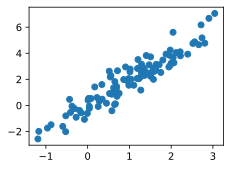

In [6]:
d2l.set_figsize()
d2l.plt.scatter(data[:100, 0].detach().numpy(),
                data[:100, 1].detach().numpy());
print(f'The covariance matrix is\n{torch.matmul(A.T, A)}')

In [7]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

### 20.1.2. Generator

In [8]:
net_G = nn.Sequential(nn.Linear(2, 2))

### 20.1.3. Discriminator

In [9]:
net_D = nn.Sequential(
    nn.Linear(2, 5),
    nn.Tanh(),
    nn.Linear(5, 3),
    nn.Tanh(),
    nn.Linear(3, 1),
)

### 20.1.4. Training

In [14]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    '''Update discriminator'''
    batch_size = X.shape[0]

    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)

    # zero out gradients for D
    trainer_D.zero_grad()
    # real data prediction on D
    real_Y = net_D(X)
    # generate fake data
    fake_X = net_G(Z)

    # do not need to compute gradient for net_G,
    # detach it from computing gradients
    fake_Y = net_D(fake_X.detach())
    # compute loss for real and fake data
    loss_D = (
        loss(real_Y, ones.reshape(real_Y.shape)) + # real data loss
        loss(fake_Y, zeros.reshape(fake_Y.shape)) # fake data loss
    ) / 2
    # compute gradient
    loss_D.backward()
    # update parameters
    trainer_D.step()

    return loss_D

In [15]:
def update_G(Z, net_D, net_G, loss, trainer_G):
    '''Update generator'''
    batch_size = Z.shape[0]

    ones = torch.ones((batch_size,), device=Z.device)
    # zero out gradients for G
    trainer_G.zero_grad()
    # reuse fake_X from update_D to save computation
    # or generate new fake_X
    fake_X = net_G(Z)
    # compute fake_Y since net_D is updated
    fake_Y = net_D(fake_X)
    # compute loss for fake data, 
    # but for G, we want D to predict fake data as real
    # so we use ones instead of zeros
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    # compute gradient
    loss_G.backward()
    # update parameters
    trainer_G.step()

    return loss_G

Both the discriminator and the generator performs a binary logistic regression with the cross-entropy loss. We use Adam to smooth the training process. In each iteration, we first update the discriminator and then the generator. 

In [16]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = nn.BCEWithLogitsLoss(reduction='sum')

    for w in net_D.parameters():
        # initialize D's parameters
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        # initialize G's parameters
        nn.init.normal_(w, 0, 0.02)

    # create optimizers for D and G
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)

    # create animator
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs],
                            nrows=2,
                            figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    # start training
    for epoch in range(num_epochs):
        # train one epoch
        timer = d2l.Timer()
        # use metric to accumulate loss
        metric = d2l.Accumulator(3) # loss_D, loss_G, num_examples

        for (X,) in data_iter:
            batch_size = X.shape[0]
            # generate latent variable Z
            Z = torch.normal(0, 1, size=(batch_size, latent_dim))
            # add to metric
            metric.add(
                update_D(X, Z, net_D, net_G, loss, trainer_D),
                update_G(Z, net_D, net_G, loss, trainer_G),
                batch_size,
            )

        # visualize generated examples
        Z = torch.normal(0, 1, size=(100, latent_dim))
        fake_X = net_G(Z).detach().numpy()
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(['real', 'generated'])
        # show losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(
            epoch + 1,
            (loss_D, loss_G)
        )

    print(f'loss_D: {loss_D:.3f}, loss_G: {loss_G:.3f}, {metric[2] / timer.stop():.1f} examples/sec')        

loss_D: 0.693, loss_G: 0.693, 2015.9 examples/sec


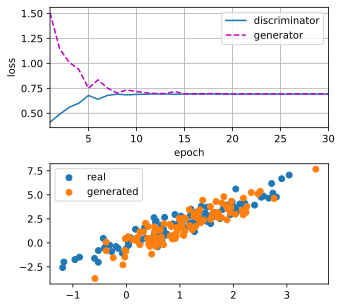

In [17]:
lr_D = 0.05
lr_G = 0.005
latent_dim = 2
num_epochs = 30

train(net_D, net_G, data_iter, num_epochs, 
      lr_D, lr_G, latent_dim, 
      data[:100].detach().numpy())

## 20.2. Deep Convolutional Generative Adversarial Networks

In [1]:
import warnings
import torch
import torchvision
from torch import nn

from d2l import torch as d2l

### 20.2.1. The Pokemon Dataset

The Pokemon dataset (https://pokemondb.net/sprites) is a collection of Pokemon sprites.

In [3]:
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

We will resize each image into $64\times 64$. The `ToTensor` transformation will project the pixel value into $[0, 1]$, while the generator we define later will use the `tanh` function to obtain outputs in $[-1, 1]$. Therefore we normalize the data with 0.5 mean and 0.5 standard deviation to match the value range.

In [4]:
batch_size = 256

tranforms_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=0.5, std=0.5)
])

pokemon.transform = tranforms_train

data_iter = torch.utils.data.DataLoader(
    pokemon,
    batch_size=batch_size,
    shuffle=True,
    num_workers=d2l.get_dataloader_workers()
)

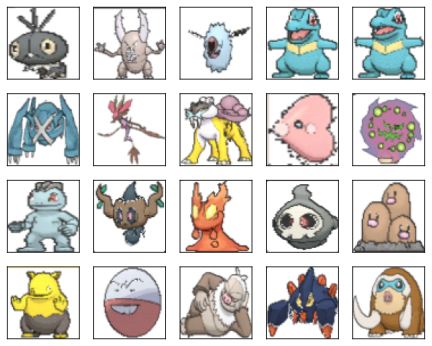

In [23]:
# plot the first 20 images
warnings.filterwarnings('ignore')
d2l.set_figsize((4, 4))

for X, y in data_iter:
    imgs = X[:20, :, :, :]
    # move channel to the last dimension
    imgs = imgs.permute(0, 2, 3, 1)
    # reverse normalization
    imgs = imgs / 2 + 0.5

    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

### 20.2.2. The Generator

The generator needs to map the noise variable $\mathbf z\in\mathbb R^d$, a length-$d$ vector, to a RGB image with width and height to be $64\times 64$. We can use the transposed convolution layers in FCN to enlarge input size. The basic block of the generator (`G_block`) contains a transposed convolution layer followed by the batch normalization and ReLU activation.

In [5]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2, padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(
            in_channels, out_channels,
            kernel_size, strides, padding, bias=False
        )
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        X = self.conv2d_trans(X)
        X = self.batch_norm(X)
        return self.activation(X)

In default, this transposed convolution layer uses a kernel of $4\times 4$, a stride of $2\times 2$, and a padding of $1\times 1$. Given an input shape of $16\times 16$, the generator block will double its width and height to $32\times 32$. 

In [6]:
X = torch.zeros((1, 3, 16, 16)) # for one 16x16 image

g_blk = G_block(out_channels=20)
g_blk(X).shape

torch.Size([1, 20, 32, 32])

If we change the transposed convolution layer to use a kernel of $4\times 4$, a stride of $1\times 1$, and zero padding, the generator block will increase the width and height of the input by 3:

In [7]:
X = torch.zeros((1, 3, 16, 16)) # for one 16x16 image

g_blk = G_block(out_channels=20, strides=1, padding=0)
g_blk(X).shape

torch.Size([1, 20, 19, 19])

The generator will consist of 4 basic blocks that increase input size from $1\times 1$ to $32\times 32$. It first projects the latent variable into $64\times 8$ channels, and then halves the channels each time. Finally, a transposed convolution layer is used to generate the output, and further doubles the width and height to $64\times 64$ and reduces the channel size to 3. The tanh activation function is applied to project the output into the $[-1, 1]$ range. 

In [8]:
n_G = 64

net_G = nn.Sequential(
    G_block(
        in_channels=100, out_channels=n_G * 8, strides=1, padding=0, 
    ), # output: (64 * 8, 4, 4)
    G_block(
        in_channels=n_G * 8, out_channels=n_G * 4, 
    ), # output: (64 * 4, 8, 8)
    G_block(
        in_channels=n_G * 4, out_channels=n_G * 2, 
    ), # output: (64 * 2, 16, 16)
    G_block(
        in_channels=n_G * 2, out_channels=n_G, 
    ), # output: (64, 32, 32)
    nn.ConvTranspose2d(
        in_channels=n_G, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False
    ), # output: (3, 64, 64)

    nn.Tanh()
)

Generate a 100-dimensional latent vector to verify the generator's output shape:

In [9]:
X = torch.zeros((1, 100, 1, 1)) # 100-dim latent variable

net_G(X).shape

torch.Size([1, 3, 64, 64])

### 20.2.3. The Discriminator

The discriminator is a normal CNN except that it uses a leaky ReLU as its activation function. Given $\alpha\in[0,1]$, its definition is
\begin{split}
\textrm{leaky ReLU}(x) = \begin{cases}x & \textrm{if}\ x > 0\\ \alpha x &\textrm{otherwise}\end{cases}.
\end{split}

It aims to fix the "dying ReLU" problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of ReLU is 0.

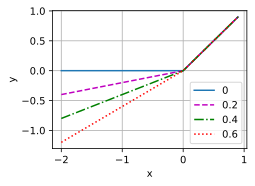

In [10]:
alphas = [0, .2, .4, .6, .8, 1]

x = torch.arange(-2, 1, 0.1)
Y = [nn.LeakyReLU(alpha)(x).detach().numpy() for alpha in alphas]

d2l.plot(x.detach().numpy(), Y, 'x', 'y', alphas)

The basic block of the discriminator is a convolution layer followed by a batch normalization layer and a leaky ReLU activation.

In [11]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, 
                 kernel_size=4, strides=2, padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        X = self.conv2d(X)
        X = self.batch_norm(X)

        return self.activation(X)

A basic block with default settings will halve the width and height of the inputs:

In [12]:
x = torch.zeros((1, 3, 16, 16))

d_blk = D_block(20)
d_blk(x).shape

torch.Size([1, 20, 8, 8])

The discriminator is a mirror of the generator:

In [13]:
n_D = 64

net_D = nn.Sequential(
    D_block(n_D), # output: (64, 32, 32)
    D_block(in_channels=n_D, out_channels=n_D*2), # output: (64*2, 16, 16)
    D_block(in_channels=n_D*2, out_channels=n_D*4), # output: (64*4, 8, 8)
    D_block(in_channels=n_D*4, out_channels=n_D*8), # output: (64*8, 4, 4)
    nn.Conv2d(in_channels=n_D*8, out_channels=1, kernel_size=4, bias=False), # output: (1, 1, 1)
)

In [14]:
x = torch.zeros((1, 3, 64, 64))
net_D(x).shape

torch.Size([1, 1, 1, 1])

### 20.2.4. Training

In [15]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim, device=d2l.try_gpu()):
    loss = nn.BCEWithLogitsLoss(reduction='sum')

    # initialize weight parameters
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)

    net_D = net_D.to(device)
    net_G = net_G.to(device)

    # create optimizers
    trainer_hp = {'lr': lr, 'betas': [0.5, 0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)

    # create an animator
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5,5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    # trianing
    for epoch in range(1, num_epochs + 1):
        # train one epoch
        timer = d2l.Timer()
        # create a metric
        metric = d2l.Accumulator(3) # loss_D, loss_G, num_examples

        for X, _ in data_iter:
            batch_size = X.shape[0]
            # Create latent vector
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X = X.to(device)
            Z = Z.to(device)

            # record metric
            metric.add(
                d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                batch_size
            )

        # show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        fake_x = net_G(Z)
        # move channels to the last dim
        fake_x = fake_x.permute(0, 2, 3, 1)
        # reverse normalization
        fake_x = fake_x / 2 + 0.5

        imgs = torch.cat(
            [torch.cat(
                [fake_x[i * 7 + j].cpu().detach() for j in range(7)], dim=1
            ) for i in range(len(fake_x)//7)], dim=0
        )

        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)

        # show the loss
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]

    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

loss_D 0.014, loss_G 8.229, 279.2 examples/sec on cuda:0


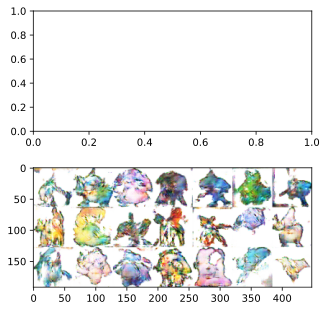

In [16]:
latent_dim = 100
lr = 0.005
num_epochs = 30

train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)